## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,RFE
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2
from scipy.stats import pearsonr, ttest_ind
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.svm import LinearSVC
import warnings
warnings.filterwarnings('ignore')

## Feature Selection Class Implementation


In [2]:
class FeatureSelector:
    def __init__(self, X, y, feature_names=None):
        """
        Initialize the feature selector
        
        Parameters:
        -----------
        X : array-like
            Feature matrix
        y : array-like
            Target labels
        feature_names : list or array-like
            Names of the features
        """
        self.X = X
        # Encode the target variable
        self.label_encoder = LabelEncoder()
        self.y = self.label_encoder.fit_transform(y)
        self.y_original = y  # Keep original labels for display
        # Convert feature_names to list if it's a pandas Index
        self.feature_names = list(feature_names) if feature_names is not None else [f'feature_{i}' for i in range(X.shape[1])]
        self.scaler = StandardScaler()
        self.X_scaled = self.scaler.fit_transform(X)
        
    def statistical_selection(self, k=10, method='f_classif'):
        """
        Perform statistical feature selection using ANOVA F-value or mutual information
        
        Parameters:
        -----------
        k : int
            Number of features to select
        method : str
            'f_classif' for ANOVA F-value or 'mutual_info' for mutual information
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Feature scores
        """
        if method == 'f_classif':
            selector = SelectKBest(f_classif, k=k)
            scores = f_classif(self.X_scaled, self.y)[0]
        else:
            selector = SelectKBest(mutual_info_classif, k=k)
            scores = mutual_info_classif(self.X_scaled, self.y)
            
        selector.fit(self.X_scaled, self.y)
        selected_indices = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, scores
    
    def random_forest_selection(self, k=10, n_estimators=100):
        """
        Perform feature selection using Random Forest importance
        
        Parameters:
        -----------
        k : int
            Number of features to select
        n_estimators : int
            Number of trees in the random forest
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        importances : array
            Feature importances
        """
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rf.fit(self.X_scaled, self.y)
        importances = rf.feature_importances_
        
        # Get indices of top k features
        selected_indices = np.argsort(importances)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, importances
    
    def pca_selection(self, n_components=0.95):
        """
        Perform feature selection using PCA
        
        Parameters:
        -----------
        n_components : float or int
            Number of components to keep (float for variance ratio)
            
        Returns:
        --------
        explained_variance_ratio : array
            Explained variance ratio for each component
        """
        pca = PCA(n_components=n_components)
        pca.fit(self.X_scaled)
        return pca.explained_variance_ratio_
  
    def plot_pca_variance(self, explained_variance_ratio):
        """
        Plot PCA explained variance ratio
        
        Parameters:
        -----------
        explained_variance_ratio : array
            Explained variance ratio for each component
        """
        plt.figure(figsize=(10, 6))
        plt.plot(np.cumsum(explained_variance_ratio), 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('PCA Explained Variance Ratio')
        plt.grid(True)
        plt.show()
    
    def evaluate_selection(self, selected_features, method_name):
        """
        Evaluate the selected features using cross-validation
        
        Parameters:
        -----------
        selected_features : list
            Names of selected features
        method_name : str
            Name of the feature selection method
        """
        # Get indices of selected features using list comprehension
        selected_indices = [i for i, f in enumerate(self.feature_names) if f in selected_features]
        X_selected = self.X_scaled[:, selected_indices]
        
        # Evaluate using Random Forest
        rf = RandomForestClassifier(n_estimators=100, random_state=42)
        scores = cross_val_score(rf, X_selected, self.y, cv=5)
        
        print(f"\n{method_name} Results:")
        print(f"Number of selected features: {len(selected_features)}")
        print(f"Cross-validation accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
        print("\nSelected features:")
        for feature in selected_features:
            print(f"- {feature}")
        print("\nClass mapping:")
        for i, label in enumerate(self.label_encoder.classes_):
            print(f"{i}: {label}")
    
    def correlation_selection(self, k=10, threshold=0.8):
        """
        Select features based on correlation with target and between features
        
        Parameters:
        -----------
        k : int
            Number of features to select
        threshold : float
            Maximum correlation threshold between features
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Correlation scores with target
        """
        # Calculate correlation with target
        correlations = []
        for i in range(self.X.shape[1]):
            corr, _ = pearsonr(self.X_scaled[:, i], self.y)
            correlations.append(abs(corr))
        
        correlations = np.array(correlations)
        
        # Select features with highest correlation to target
        # while ensuring low correlation between selected features
        selected_indices = []
        remaining_indices = list(range(self.X.shape[1]))
        
        while len(selected_indices) < k and remaining_indices:
            # Find feature with highest correlation to target
            best_idx = remaining_indices[np.argmax(correlations[remaining_indices])]
            selected_indices.append(best_idx)
            
            # Remove highly correlated features
            if len(remaining_indices) > 1:
                corr_matrix = np.corrcoef(self.X_scaled[:, remaining_indices].T)
                to_remove = []
                for i, idx in enumerate(remaining_indices):
                    if idx != best_idx:
                        if abs(corr_matrix[remaining_indices.index(best_idx), i]) > threshold:
                            to_remove.append(idx)
                remaining_indices = [idx for idx in remaining_indices if idx not in to_remove]
            remaining_indices.remove(best_idx)
        
        selected_features = [self.feature_names[i] for i in selected_indices]
        return selected_features, correlations
    
    def lasso_selection(self, k=10):
        """
        Select features using LASSO regularization
        
        Parameters:
        -----------
        k : int
            Number of features to select
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            LASSO coefficients
        """
        # Use LogisticRegression with L1 penalty for classification
        lasso = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, max_iter=1000)
        lasso.fit(self.X_scaled, self.y)
        
        # Get absolute coefficients
        coefficients = np.abs(lasso.coef_[0])  # Take first class coefficients
        
        # Select top k features
        selected_indices = np.argsort(coefficients)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, coefficients
    
    def rfe_selection(self, k=10, n_estimators=100):
        """
        Select features using Recursive Feature Elimination
        
        Parameters:
        -----------
        k : int
            Number of features to select
        n_estimators : int
            Number of trees for Random Forest estimator
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Feature rankings (1 is best)
        """
        estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
        rfe = RFE(estimator=estimator, n_features_to_select=k, step=1)
        rfe.fit(self.X_scaled, self.y)
        
        selected_indices = np.where(rfe.support_)[0]
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, rfe.ranking_
    
    def chi2_selection(self, k=10):
        """
        Select features using Chi-square test
        
        Parameters:
        -----------
        k : int
            Number of features to select
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Chi-square scores
        """
        # Ensure data is non-negative for chi2
        X_positive = self.X_scaled - self.X_scaled.min() + 1e-6
        
        selector = SelectKBest(chi2, k=k)
        selector.fit(X_positive, self.y)
        
        selected_indices = selector.get_support(indices=True)
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, selector.scores_

    def ttest_selection(self, k=10, alpha=0.05):
        """
        Select features using t-test for each class pair
        
        Parameters:
        -----------
        k : int
            Number of features to select
        alpha : float
            Significance level for t-test
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Minimum p-values across all class pairs
        """
        classes = np.unique(self.y)
        n_features = self.X_scaled.shape[1]
        min_pvalues = np.ones(n_features)
        
        # Perform t-test for each pair of classes
        for i in range(len(classes)):
            for j in range(i+1, len(classes)):
                class1 = self.X_scaled[self.y == classes[i]]
                class2 = self.X_scaled[self.y == classes[j]]
                
                # Perform t-test for each feature
                t_stats, p_values = ttest_ind(class1, class2)
                min_pvalues = np.minimum(min_pvalues, p_values)
        
        # Select features with smallest p-values
        selected_indices = np.argsort(min_pvalues)[:k]
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, -np.log10(min_pvalues)  # Convert to -log10(p-value) for better visualization
    
    def elastic_net_selection(self, k=10, l1_ratio=0.5):
        """
        Select features using Elastic Net regularization
        
        Parameters:
        -----------
        k : int
            Number of features to select
        l1_ratio : float
            Mixing parameter for L1 and L2 regularization
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Absolute coefficients
        """
        # Use LogisticRegression with elastic net penalty
        elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', 
                                        l1_ratio=l1_ratio, random_state=42, max_iter=1000)
        elastic_net.fit(self.X_scaled, self.y)
        
        # Get absolute coefficients
        coefficients = np.abs(elastic_net.coef_[0])  # Take first class coefficients
        
        # Select top k features
        selected_indices = np.argsort(coefficients)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, coefficients
    
    def svm_based_selection(self, k=10):
        """
        Select features using SVM-based feature selection
        
        Parameters:
        -----------
        k : int
            Number of features to select
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Feature importance scores
        """
        # Use LinearSVC with L1 regularization
        svm = LinearSVC(penalty='l1', dual=False, random_state=42)
        svm.fit(self.X_scaled, self.y)
        
        # Get absolute coefficients
        coefficients = np.abs(svm.coef_).mean(axis=0)  # Average across classes
        
        # Select top k features
        selected_indices = np.argsort(coefficients)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, coefficients
    
    def gradient_boosting_selection(self, k=10, n_estimators=100):
        """
        Select features using Gradient Boosting importance
        
        Parameters:
        -----------
        k : int
            Number of features to select
        n_estimators : int
            Number of boosting stages
            
        Returns:
        --------
        selected_features : list
            Names of selected features
        scores : array
            Feature importance scores
        """
        gb = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)
        gb.fit(self.X_scaled, self.y)
        
        # Get feature importances
        importances = gb.feature_importances_
        
        # Select top k features
        selected_indices = np.argsort(importances)[-k:]
        selected_features = [self.feature_names[i] for i in selected_indices]
        
        return selected_features, importances

    def find_optimal_features(self, method='f_classif', feature_range=None, n_estimators=100):
        """
        Find the optimal number of features using cross-validation
        
        Parameters:
        -----------
        method : str
            Feature selection method
        feature_range : list or None
            Range of features to try
        n_estimators : int
            Number of trees for Random Forest
            
        Returns:
        --------
        best_k : int
            Optimal number of features
        best_score : float
            Best cross-validation score
        results : dict
            Dictionary containing results for all k values
        """
        if feature_range is None:
            feature_range = [5, 10, 15, 20, 25, 30]
        
        results = {'k': [], 'score': [], 'std': []}
        best_score = -np.inf
        best_k = None
        
        for k in feature_range:
            if k > self.X.shape[1]:
                continue
                
            try:
                if method == 'f_classif':
                    selected_features, _ = self.statistical_selection(k=k, method='f_classif')
                elif method == 'mutual_info':
                    selected_features, _ = self.statistical_selection(k=k, method='mutual_info')
                elif method == 'random_forest':
                    selected_features, _ = self.random_forest_selection(k=k, n_estimators=n_estimators)
                elif method == 'correlation':
                    selected_features, _ = self.correlation_selection(k=k)
                elif method == 'lasso':
                    selected_features, _ = self.lasso_selection(k=k)
                elif method == 'rfe':
                    selected_features, _ = self.rfe_selection(k=k, n_estimators=n_estimators)
                elif method == 'chi2':
                    selected_features, _ = self.chi2_selection(k=k)
                elif method == 'ttest':
                    selected_features, _ = self.ttest_selection(k=k)
                elif method == 'elastic_net':
                    selected_features, _ = self.elastic_net_selection(k=k)
                elif method == 'svm':
                    selected_features, _ = self.svm_based_selection(k=k)
                elif method == 'gradient_boosting':
                    selected_features, _ = self.gradient_boosting_selection(k=k, n_estimators=n_estimators)
                else:
                    raise ValueError(f"Unknown method: {method}")
                
                # Get indices of selected features using list comprehension
                selected_indices = [i for i, f in enumerate(self.feature_names) if f in selected_features]
                X_selected = self.X_scaled[:, selected_indices]
                
                # Evaluate using Random Forest
                rf = RandomForestClassifier(n_estimators=100, random_state=42)
                scores = cross_val_score(rf, X_selected, self.y, cv=5)
                mean_score = scores.mean()
                std_score = scores.std()
                
                results['k'].append(k)
                results['score'].append(mean_score)
                results['std'].append(std_score)
                
                if mean_score > best_score:
                    best_score = mean_score
                    best_k = k
                    
            except Exception as e:
                print(f"Error with k={k}: {str(e)}")
                continue
        
        if not results['k']:  # If no successful runs
            raise ValueError(f"No successful feature selection runs for method {method}")
            
        # Plot results
        plt.figure(figsize=(10, 6))
        plt.errorbar(results['k'], results['score'], yerr=results['std'], fmt='o-', capsize=5)
        plt.xlabel('Number of Features')
        plt.ylabel('Cross-validation Score')
        plt.title(f'Feature Selection Performance - {method}')
        plt.grid(True)
        plt.show()
        
        return best_k, best_score, results

## Code Usage

Dataset shape: (7590, 55)
Number of features: 54
Number of samples: 7590
Class distribution:
class
normal       2699
alzheimer    2500
parkinson    2391
Name: count, dtype: int64

Finding optimal features using f_classif...


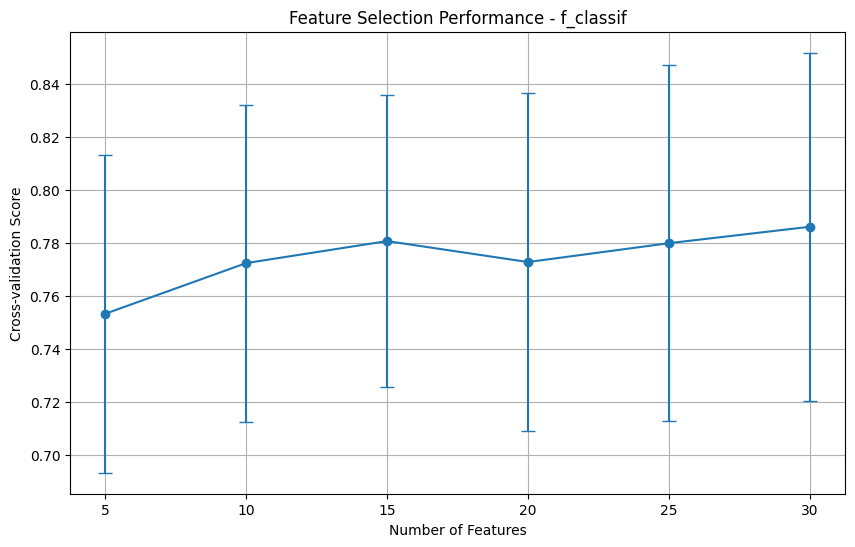

Best number of features: 30
Best cross-validation score: 0.786

Finding optimal features using mutual_info...


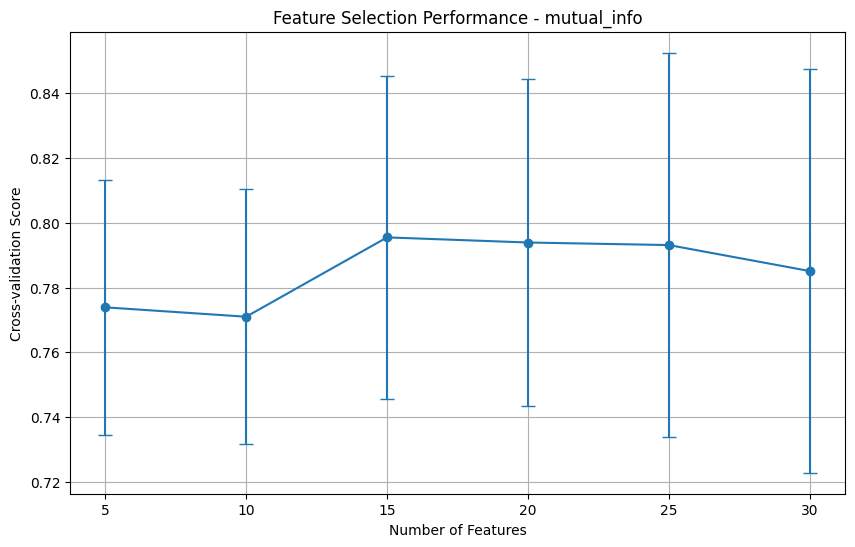

Best number of features: 15
Best cross-validation score: 0.796

Finding optimal features using random_forest...


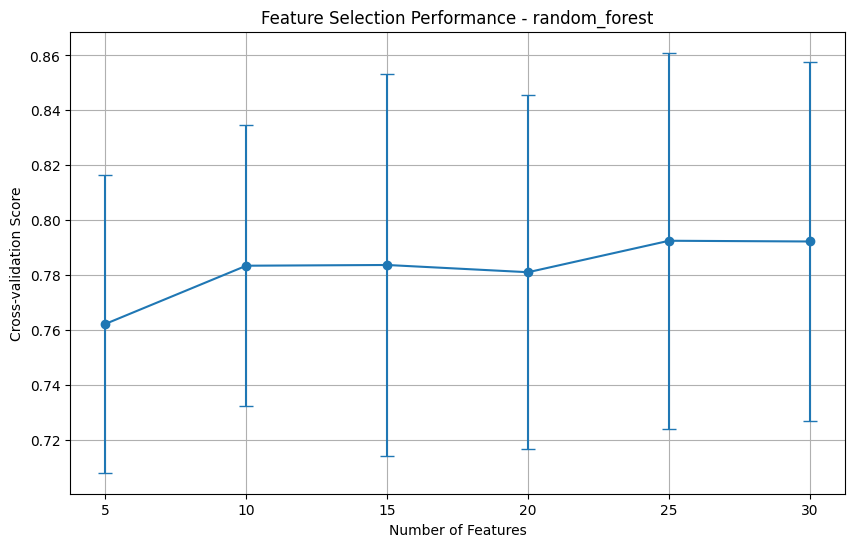

Best number of features: 25
Best cross-validation score: 0.792

Finding optimal features using correlation...


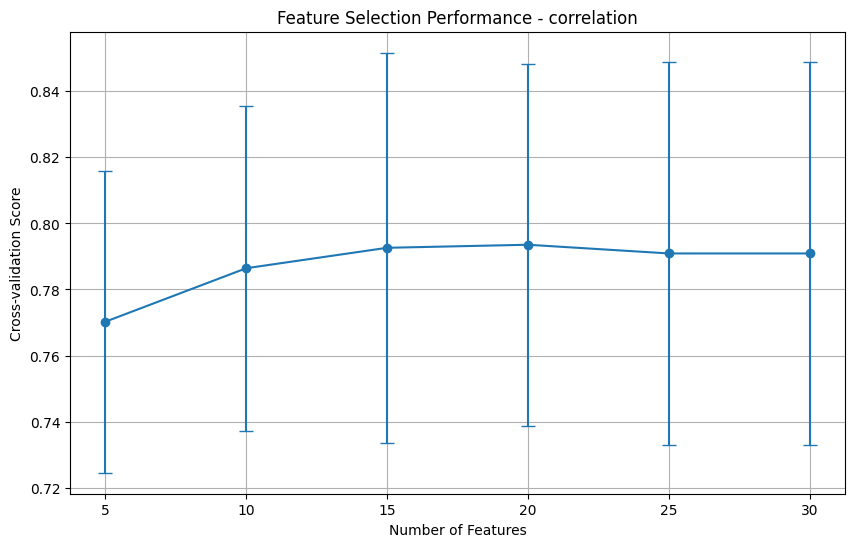

Best number of features: 20
Best cross-validation score: 0.794

Finding optimal features using lasso...


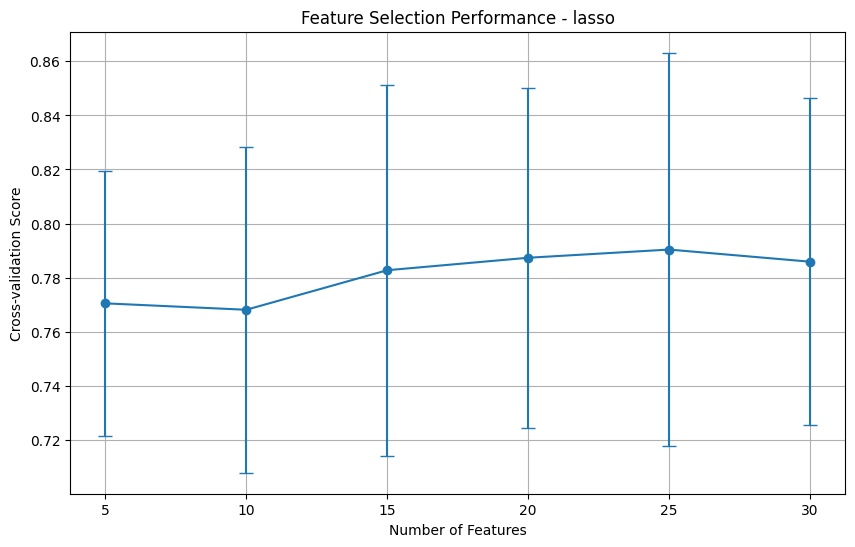

Best number of features: 25
Best cross-validation score: 0.790

Finding optimal features using rfe...


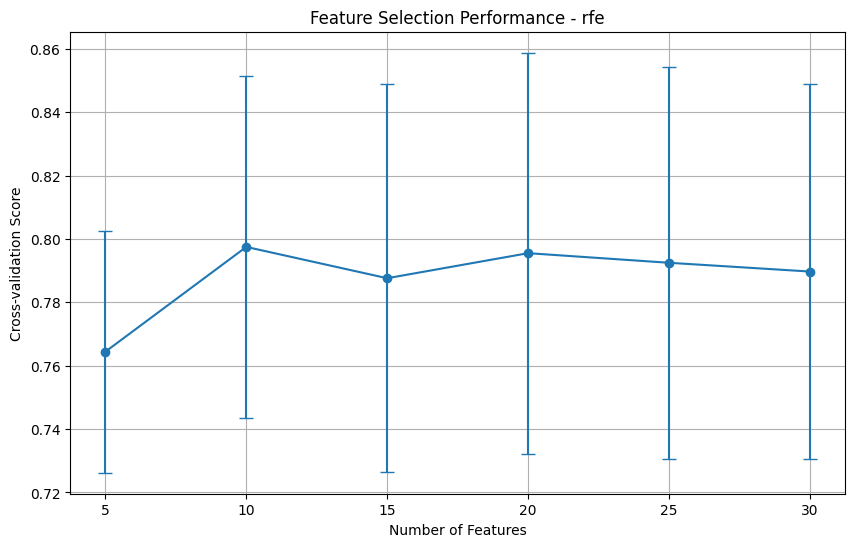

Best number of features: 10
Best cross-validation score: 0.797

Finding optimal features using ttest...


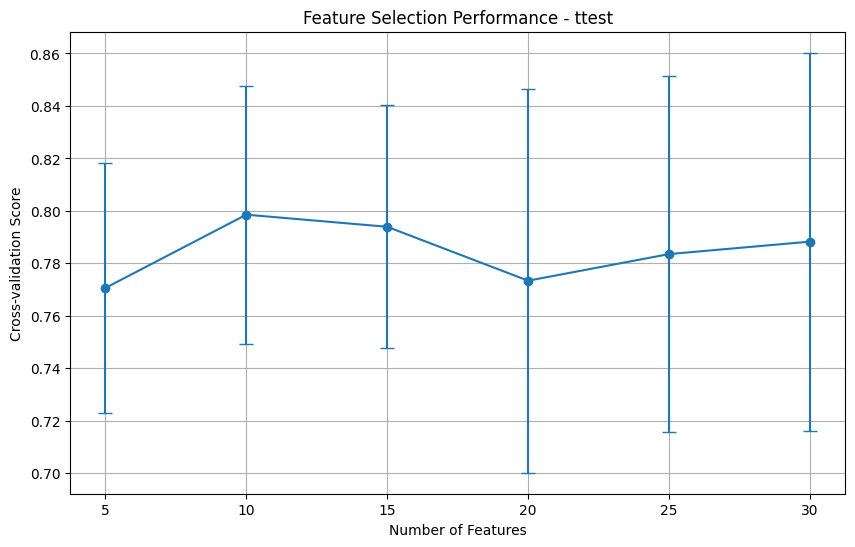

Best number of features: 10
Best cross-validation score: 0.799

Finding optimal features using elastic_net...


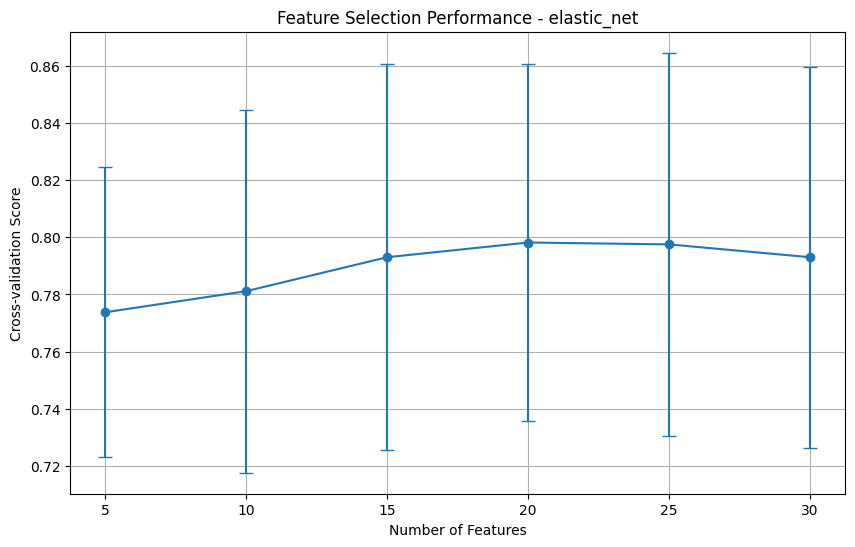

Best number of features: 20
Best cross-validation score: 0.798

Finding optimal features using svm...


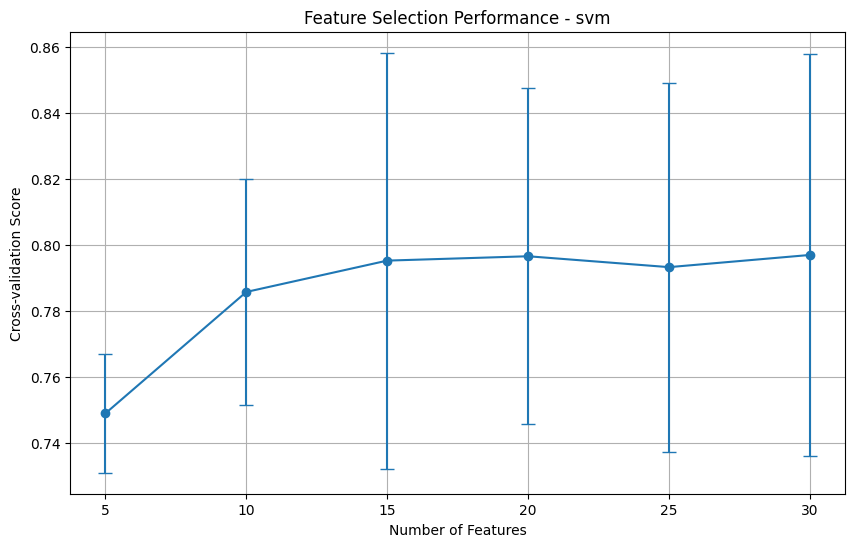

Best number of features: 30
Best cross-validation score: 0.797

Finding optimal features using gradient_boosting...


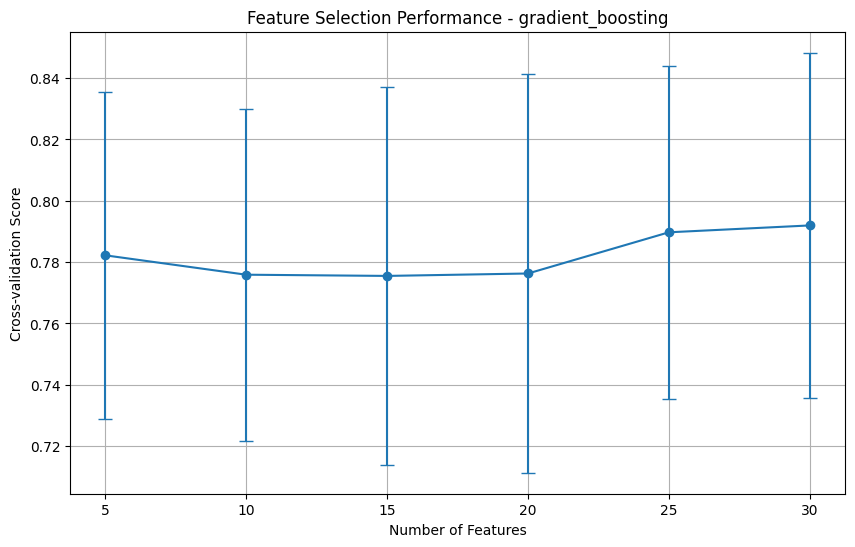

Best number of features: 30
Best cross-validation score: 0.792

Best performing method: ttest
Optimal number of features: 10

Best Method (ttest) Results:
Number of selected features: 10
Cross-validation accuracy: 0.799 (+/- 0.098)

Selected features:
- mean
- std
- skewness
- kurtosis
- entropy
- wavelet_HL_entropy
- glcm_contrast
- p75
- p90
- wavelet_HH_std

Class mapping:
0: alzheimer
1: normal
2: parkinson

Selected features have been saved to 'selected_features.csv'
Method comparison has been saved to 'method_comparison.csv'


In [3]:
# Read the data from csv file
data = pd.read_csv('./brain_mri_features.csv')

# Drop the filename column as it's not needed for feature selection
data = data.drop(columns=['filename'])

# Separate features and target
X = data.drop(columns=['class'])
y = data['class']

# Convert feature names to list
feature_names = list(X.columns)

# Print some information about the dataset
print(f"Dataset shape: {data.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")
print(f"Class distribution:\n{y.value_counts()}")

# Initialize feature selector with list of feature names
selector = FeatureSelector(X, y, feature_names)

# Find optimal number of features for each method
methods = [
    'f_classif',  # Fisher Score
    'mutual_info',
    'random_forest',
    'correlation',
    'lasso',
    'rfe',
    'ttest',           
    'elastic_net',     
    'svm',
    'gradient_boosting'
]
best_results = {}

for method in methods:
    print(f"\nFinding optimal features using {method}...")
    try:

        feature_range = [5, 10, 15, 20, 25, 30]
        best_k, best_score, results = selector.find_optimal_features(method=method, feature_range=feature_range)
        best_results[method] = {
            'best_k': best_k,
            'best_score': best_score,
            'all_results': results
        }
        print(f"Best number of features: {best_k}")
        print(f"Best cross-validation score: {best_score:.3f}")
    except Exception as e:
        print(f"Error with {method}: {str(e)}")
        continue

# Use the best method and optimal k
if best_results:
    best_method = max(best_results.items(), key=lambda x: x[1]['best_score'])[0]
    best_k = best_results[best_method]['best_k']
    
    print(f"\nBest performing method: {best_method}")
    print(f"Optimal number of features: {best_k}")
    
    # Get final selected features using the best method and k
    if best_method == 'f_classif':  # Fisher Score
        selected_features, scores = selector.statistical_selection(k=best_k, method='f_classif')
    elif best_method == 'mutual_info':
        selected_features, scores = selector.statistical_selection(k=best_k, method='mutual_info')
    elif best_method == 'random_forest':
        selected_features, scores = selector.random_forest_selection(k=best_k)
    elif best_method == 'correlation':
        selected_features, scores = selector.correlation_selection(k=best_k)
    elif best_method == 'lasso':
        selected_features, scores = selector.lasso_selection(k=best_k)
    elif best_method == 'rfe':
        selected_features, scores = selector.rfe_selection(k=best_k)
    elif best_method == 'ttest':
        selected_features, scores = selector.ttest_selection(k=best_k)
    elif best_method == 'elastic_net':
        selected_features, scores = selector.elastic_net_selection(k=best_k)
    elif best_method == 'svm':
        selected_features, scores = selector.svm_based_selection(k=best_k)
    elif best_method == 'gradient_boosting':
        selected_features, scores = selector.gradient_boosting_selection(k=best_k)
            
    # Evaluate the selected features
    selector.evaluate_selection(selected_features, f'Best Method ({best_method})')
    
    # Save selected features to a file
    results = {
        'Method': [best_method] * len(selected_features),
        'Selected_Features': selected_features,
        'Optimal_k': [best_k] * len(selected_features),
        'Best_Score': [best_results[best_method]['best_score']] * len(selected_features)
    }
    
    # Add comparison of all methods
    comparison = pd.DataFrame({
        'Method': list(best_results.keys()),
        'Best_k': [results['best_k'] for results in best_results.values()],
        'Best_Score': [results['best_score'] for results in best_results.values()]
    })
    
    # Save results to CSV files
    pd.DataFrame(results).to_csv('selected_features.csv', index=False)
    comparison.to_csv('method_comparison.csv', index=False)
    print("\nSelected features have been saved to 'selected_features.csv'")
    print("Method comparison has been saved to 'method_comparison.csv'")
else:
    print("No methods were successful in finding optimal features.")

## Not used due to high computational complexity


def sequential_forward_selection(self, k=10, n_estimators=100):
    """
    Select features using Sequential Forward Selection
    
    Parameters:
    -----------
    k : int
        Number of features to select
    n_estimators : int
        Number of trees for Random Forest estimator
        
    Returns:
    --------
    selected_features : list
        Names of selected features
    scores : array
        Cross-validation scores for each step
    """
    estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    sfs = SFS(estimator,
                k_features=k,
                forward=True,
                floating=False,
                scoring='accuracy',
                cv=5,
                n_jobs=-1)
    
    sfs.fit(self.X_scaled, self.y)
    
    # Get selected feature indices
    selected_indices = list(sfs.k_feature_idx_)
    selected_features = [self.feature_names[i] for i in selected_indices]
    
    # Get scores for each step
    scores = np.array([score for score in sfs.subsets_.values()])
    
    return selected_features, scores

def sequential_backward_selection(self, k=10, n_estimators=100):
    """
    Select features using Sequential Backward Selection
    
    Parameters:
    -----------
    k : int
        Number of features to select
    n_estimators : int
        Number of trees for Random Forest estimator
        
    Returns:
    --------
    selected_features : list
        Names of selected features
    scores : array
        Cross-validation scores for each step
    """
    estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    sfs = SFS(estimator,
                k_features=k,
                forward=False,
                floating=False,
                scoring='accuracy',
                cv=5,
                n_jobs=-1)
    
    sfs.fit(self.X_scaled, self.y)
    
    # Get selected feature indices
    selected_indices = list(sfs.k_feature_idx_)
    selected_features = [self.feature_names[i] for i in selected_indices]
    
    # Get scores for each step
    scores = np.array([score for score in sfs.subsets_.values()])
    
    return selected_features, scores

def exhaustive_feature_selection(self, k=10, n_estimators=100):
    """
    Select features using Exhaustive Feature Selection
    
    Parameters:
    -----------
    k : int
        Number of features to select
    n_estimators : int
        Number of trees for Random Forest estimator
        
    Returns:
    --------
    selected_features : list
        Names of selected features
    scores : array
        Cross-validation scores for each combination
    """
    estimator = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    efs = EFS(estimator,
                min_features=k,
                max_features=k,
                scoring='accuracy',
                cv=5,
                n_jobs=-1)
    
    efs.fit(self.X_scaled, self.y)
    
    # Get selected feature indices
    selected_indices = list(efs.best_idx_)
    selected_features = [self.feature_names[i] for i in selected_indices]
    
    # Get scores for each combination
    scores = np.array([score for score in efs.subsets_.values()])
    
    return selected_features, scores